In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import clone

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1a.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


features = read_data_file('CATSnDOGS.csv') / 255
labels = read_data_file('Labels.csv')

models = [
          ('SVM', SVC()),
          ('LogReg', LogisticRegression(max_iter=1000)), 
          ('RF', RandomForestClassifier())
        ]

In [5]:
def reset(models: list):
    return [(name, clone(model)) for name, model in models]


def tune_ensemble(models: list, features: pd.DataFrame, labels: pd.DataFrame) -> dict:
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, stratify=labels, random_state=None)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    tuned_models = []

    for name, model in models:
        kfold = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
        cross_validate(model, X_train, y_train.to_numpy().ravel(), cv=kfold, scoring=scoring)
        tuned_models.append((name, model))
       
    return tuned_models


def evaluate_ensemble(models: list, features: pd.DataFrame, labels: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, stratify=labels, random_state=None)
    dfs = []
    for name, model in models:
        clf = model.fit(X_train, y_train.to_numpy().ravel())
        y_pred = clf.predict(X_test)
        
        df = pd.DataFrame({'_id': y_test.index.values, 'true': y_test.to_numpy().ravel(), 'predicted': y_pred, 'model': name})
        dfs.append(df)
    
    result = pd.concat(dfs, ignore_index=True)
    return result


def average_scores(models: list, features: pd.DataFrame, labels: pd.DataFrame, iter: int=5) -> tuple:
    matrix = []
    for it in range(iter):
        res = evaluate_ensemble(models, features, labels)
        scores = calc_scores(res)
        matrix.append(scores)
    
    mean = np.mean(matrix, axis=0)
    std = np.std(matrix, axis=0)
    return mean, std

    
def calc_scores(ensemble_result: pd.DataFrame) -> np.ndarray:
    model_names = ensemble_result.model.unique()
    scores = np.zeros((len(model_names), 3))

    for i, name in enumerate(model_names):
        this_df = ensemble_result[ensemble_result.model == name]
        y_true = this_df['true']
        y_pred = this_df['predicted']

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cat_accuracy = tn / (tn + fp) # specificity
        dog_accuracy = tp / (tp + fn) # recall
        accuracy = (tn + tp)/(tn + fp + fn + tp)
        scores[i][0] = cat_accuracy
        scores[i][1] = dog_accuracy
        scores[i][2] = accuracy

    return scores


def detect_mislabels(models: list, features: pd.DataFrame, labels: pd.DataFrame, iter: int = 5, vote_limit: float = 0.5) -> dict:  
    mislabels = {}
    dfs = []

    for it in range(iter):
        res = evaluate_ensemble(models, features, labels)
        res['vote'] = np.absolute(res.true-res.predicted)
        dfs.append(res)

    df = pd.concat(dfs, ignore_index=True)
    model_names = df.model.unique()

    for i, name in enumerate(model_names):
        mislabelled_ids = []
        model_df = df[df.model == name]
        _ids = model_df._id.unique()

        for _id in _ids:
            _id_df = model_df[model_df._id == _id]
            total = len(_id_df.index)
            vote = _id_df['vote'].sum()
            
            if vote/total < vote_limit:
                continue
            else:
                mislabelled_ids.append(_id)

        mislabels[name] = mislabelled_ids

    return mislabels


def print_accuracy(mean: np.ndarray, std: np.ndarray, groups: list):
    group1 = groups[0]
    group2 = groups[1]
    names = ['SVM', 'LogReg', 'RF']
    for i, name in enumerate(names):
        print(name + " - mean accuracies (std) \n %s (specificity): %f (%f) \n %s (recall): %f (%f) \n overall: %f (%f) \n" % (group1, mean[i][0], std[i,0], group2, mean[i][1], std[i,1], mean[i][2], std[i,2]))


def mislabel_intersection(mislabels: dict):
    mislabels_svm = set(mislabels['SVM'])
    mislabels_logreg = set(mislabels['LogReg'])
    mislabels_rf = set(mislabels['RF'])

    intersection = mislabels_svm.intersection(mislabels_logreg).intersection(mislabels_rf)
    all = [('SVM', mislabels_svm), ('LogReg', mislabels_logreg), ('RF', mislabels_rf)]
    for name, mislabel in all:
        if len(mislabel) != 0:
            print("About %s percent of mislabels by the %s is shared by all models." % (np.around((len(intersection)/len(mislabel)*100), 2), name))
        else:
            print("No mislabels detected.")
    return intersection


def plot_mislabeled_images(features: pd.DataFrame, labels: pd.DataFrame, image_ids: set):
    if len(image_ids) >= 9:
        sub_sample = np.array(list(image_ids))[:9]
        fig, axes = plt.subplots(3, 3, figsize=(5,5))
        imgs = zip(sub_sample, axes.flatten())
    else:
        sub_sample = np.array(list(image_ids))
        fig, axes = plt.subplots(1, len(sub_sample), figsize=(5,5))
        imgs = zip(sub_sample, axes)
    
    for _id, ax in imgs:
        sample = features.iloc[_id,:]
        data = np.array(sample).reshape(64,64).T
        ax.imshow(data, interpolation='nearest')
        ax.axis('off')

        if labels.iat[_id,0] == 1:
            ax.set_title('True label: dog')
        else:
            ax.set_title('True label: cat')
    fig.tight_layout()
    plt.show()


tuned_models = tune_ensemble(reset(models), features, labels)
mean, std = average_scores(tuned_models, features, labels, iter=20)
mislabels = detect_mislabels(tuned_models, features, labels, iter=20, vote_limit=1.0)

SVM - mean accuracies (std) 
 cat (specificity): 0.879167 (0.065749) 
 dog (recall): 0.765385 (0.085917) 
 overall: 0.820000 (0.041473) 

LogReg - mean accuracies (std) 
 cat (specificity): 0.822917 (0.093053) 
 dog (recall): 0.730769 (0.086003) 
 overall: 0.775000 (0.055453) 

RF - mean accuracies (std) 
 cat (specificity): 0.787500 (0.108573) 
 dog (recall): 0.742308 (0.101103) 
 overall: 0.764000 (0.059532) 

About 52.38 percent of mislabels by the SVM is shared by all models.
About 39.29 percent of mislabels by the LogReg is shared by all models.
About 45.83 percent of mislabels by the RF is shared by all models.


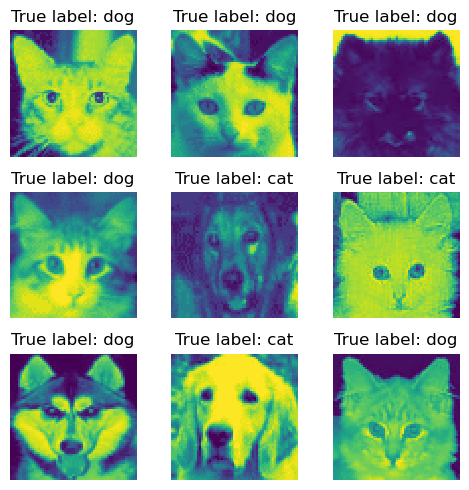

Fraction of missclassified dogs: 0.636364
Fraction of missclassified cats: 0.363636 
(according to algorithm)


In [6]:
print_accuracy(mean, std, ['cat', 'dog'])
intersection = mislabel_intersection(mislabels)

plot_mislabeled_images(features, labels, intersection)
tmp = labels.iloc[list(intersection), 0]
frac_mislabeled_dogs = tmp.sum() / len(tmp)
frac_mislabeled_cats = 1 - frac_mislabeled_dogs
print('Fraction of missclassified dogs: %f' % frac_mislabeled_dogs)
print('Fraction of missclassified cats: %f \n(according to algorithm)' % frac_mislabeled_cats)